In [16]:
#Libraries and data

import abc
import math
import random
import numpy as np
import pandas as pd
from matplotlib import rcParams
from numpy import apply_along_axis
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
np.random.seed(0)
config = {"font.family":'Times New Roman', "font.size": 10}
rcParams.update(config)
dataset = pd.read_csv('Extended Mathews.csv')
X=dataset.iloc[:,0:8]
y=dataset.iloc[:,8] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [17]:
#BCMO-MLP

class Algorithm(metaclass=abc.ABCMeta):
    def __init__(self, X_train, X_val, y_train, y_val, **kwargs):
        self.population = kwargs.pop('population', 20)
        self.iterations = kwargs.pop('iterations', 100)
        self.lower = np.array([100,0.001])
        self.upper = np.array([200,0.1])
        self.dim = 2 
        self.iter = 0
        self.eval_count = 0
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.best_solution = pd.Series(index=np.arange(1, self.dim+2), dtype=float)
        self.best_solution.rename(index={self.dim+1: 'Accuracy'}, inplace=True)
        self.iter_solution = pd.DataFrame(index=np.arange(1, self.iterations+1),columns=np.arange(1, self.dim+2))
        self.iter_solution.rename(columns={self.dim+1: 'Accuracy'}, inplace=True)
        index = pd.MultiIndex.from_product([np.arange(1, self.iterations+1), np.arange(1, self.population+1)],names=['Iteration', 'Individual'])
        columns = list(range(self.dim))
        self.iter_swarm_pos = pd.DataFrame(index=index, columns=columns)

    def initial_position(self):
        return np.random.uniform(self.lower, self.upper, [self.population, self.dim])

    def boundary_handle(self, x):
        x = np.maximum(self.lower, np.minimum(x, self.upper))
        return x

    def cost_function(self, position):
        self.eval_count += 1
        hidden_layer_sizes,alpha,  = position
        MLP_Classsifier = MLPClassifier(hidden_layer_sizes=int(hidden_layer_sizes,), activation='relu', solver='adam',
                                        alpha=alpha,batch_size='auto', learning_rate='constant',learning_rate_init=0.001,
                                        power_t=0.5, max_iter=2000, shuffle=False,random_state=None,tol=1e-4, verbose=False, warm_start=False,
                                        momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1,
                                        beta_1=0.9, beta_2=0.999, epsilon=1e-8, n_iter_no_change=10,)
        MLP_Classsifier.fit(self.X_train, self.y_train)
        y_pred = MLP_Classsifier.predict(self.X_val)
        score = 1 - accuracy_score(self.y_val, y_pred)
        return score
    
    def stopping_criteria(self, i):
        return i >= self.iterations

    def run(self):
        particle_pos = self.initial_position()
        particle_fit = apply_along_axis(self.cost_function, 1, particle_pos)
        particle_pos, particle_fit = self.sort_pop(particle_pos, particle_fit)
        # main loop
        self.iter = 0
        while not self.stopping_criteria(self.iter):
            self.iter += 1
            # Generate trial vector u1t
            u1t = self.trials_best(particle_pos)
            newObj1 = self.cost_function(u1t)
            IO_pos = particle_pos[0]
            IO_fit = particle_fit[0]
            IO_pos, IO_fit = self.update_IO(u1t, newObj1, IO_pos, IO_fit)
            self.iter_swarm_pos.loc[self.iter] = particle_pos
            self.iter_solution.loc[self.iter] = np.append(IO_pos, IO_fit)
            for ith in range(1, self.population):
                j = np.random.randint(ith + 1)
                particle_ref = particle_pos[j]
                particle_norm = self.L1normCal(IO_pos, particle_ref)
                kvj = np.exp((-(1/self.dim)*j/self.population)*particle_norm) * np.random.uniform(0, 1, self.dim)
                kvij = np.random.uniform(0, 1, self.dim)
                vj = kvj * (IO_pos - particle_pos[j])
                vij = kvij * (particle_pos[j] - particle_pos[ith])
                particle_pos[ith] = self.update_position(particle_pos[ith], vij, vj)
                particle_pos[ith] = self.boundary_handle(particle_pos[ith])
                particle_fit[ith] = self.cost_function(particle_pos[ith])
            particle_pos, particle_fit = self.sort_pop(particle_pos, particle_fit)
            gbest_pos, gbest_fit = particle_pos[0], particle_fit[0]
        self.best_solution[:] = np.append(gbest_pos, gbest_fit)
        return gbest_pos, gbest_fit

    def sort_pop(self, particle_pos, particle_fit):
        index = np.argsort(particle_fit)
        particle_fit = np.sort(particle_fit)
        particle_pos = particle_pos[index]
        return particle_pos, particle_fit

    def trials_best(self, particle_pos):
        Rnd_normal = np.random.standard_normal(self.dim)
        step = (1/self.dim)*(1/self.population)*Rnd_normal*(self.upper-self.lower)
        best_trial = particle_pos[0] + step
        return best_trial

    def update_IO(self, best_trial, newObj, IO_pos, IO_fit):
        if newObj < IO_fit:
            IO_pos = best_trial
            IO_fit = newObj
        return IO_pos, IO_fit

    def L1normCal(self, IO_pos, particle_ref):
        IO_pos = np.atleast_2d(IO_pos)
        particle_ref = np.atleast_2d(particle_ref)
        inp = np.ones((IO_pos.shape[0], self.dim)) * IO_pos - particle_ref
        abs_inp = np.abs(inp)
        return np.sum(abs_inp, axis=1, keepdims=True)

    def update_position(self, particle_pos, vij, vj):
        return particle_pos + vij + vj

if __name__ == '__main__':
    bcmo = Algorithm(X_train, X_val, y_train, y_val)
    best_sol, best_val = bcmo.run()
    print('The optimal hidden_layer_sizes:{}'.format(int(best_sol[0])))
    print('The optimal alpha:{}'.format(best_sol[1]))
    print('Output the optimal fitness：{}'.format(1 - best_val))

The optimal hidden_layer_sizes:106
The optimal alpha:0.09086556279101839
Output the optimal fitness：0.8529411764705882


In [23]:
#Model performance

import pydotplus  
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
np.random.seed(0)

hidden_layer_sizes = 106
alpha = 0.09086556279101839

MLP_Classsifier_Test = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes,), activation='relu',  solver="adam",  alpha= alpha,  batch_size='auto',  
                          learning_rate='constant', learning_rate_init=0.001,   power_t=0.5, 
                          max_iter=2000, shuffle=False, random_state=None,tol=1e-4, verbose=False, warm_start=False, 
                          momentum=0.9,  nesterovs_momentum=True,early_stopping=False,
                          validation_fraction=0.1,   beta_1=0.9,  beta_2=0.999,   epsilon=1e-8,   n_iter_no_change=10,)
MLP_Classsifier_Test.fit(X_train, y_train)

y_true_test = y_test
y_pred_test = MLP_Classsifier_Test.predict(X_test)
y_true_train = y_train
y_pred_train = MLP_Classsifier_Test.predict(X_train)

print("********************* Performance results (Training set) *********************")
print("Training accuracy:", accuracy_score(y_true_train, y_pred_train))
print("Training precision:", precision_score(y_true_train, y_pred_train,pos_label=0))
print("Training recall:", recall_score(y_true_train, y_pred_train,pos_label=0))
print("********************* Performance results (Test set) *********************")
print("Test accuracy::", accuracy_score(y_true_test, y_pred_test))
print("Test precision:", precision_score(y_true_test, y_pred_test,pos_label=0))
print("Test recall:", recall_score(y_true_test, y_pred_test,pos_label=0))

********************* Performance results (Training set) *********************
Training accuracy: 0.9375
Training precision: 0.9365079365079365
Training recall: 0.9725274725274725
********************* Performance results (Test set) *********************
Test accuracy:: 0.9069767441860465
Test precision: 0.9090909090909091
Test recall: 0.9433962264150944


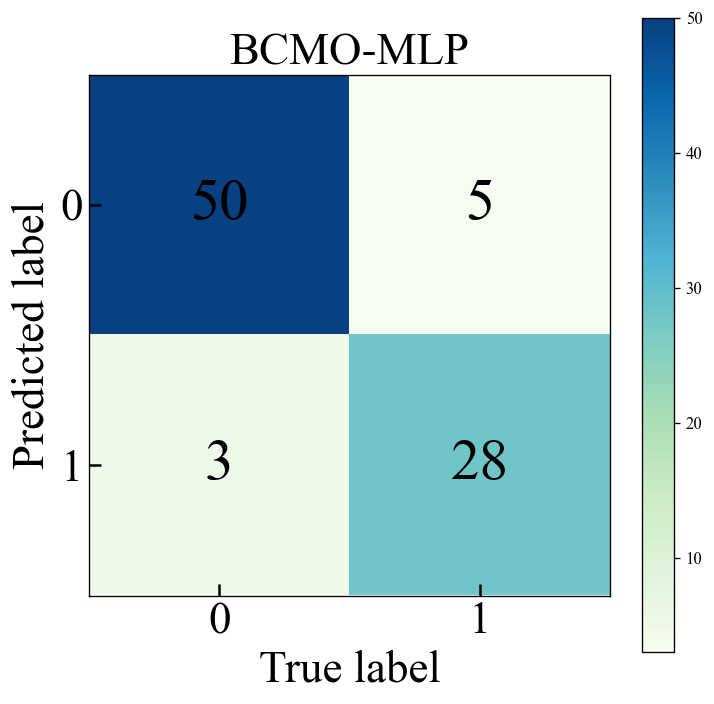

In [24]:
#Confusion matrix

%matplotlib inline
labels = list(set(y_true_test))
def plot_confuse_data(model, y_true_test, y_pred_test):
    confusion = confusion_matrix(y_true_test, y_pred_test)
    plt.imshow(confusion, cmap=plt.cm.GnBu)
    indices = range(len(confusion))
    plt.tick_params(direction='in',which='major',width=1.5,length=7)
    plt.xticks(indices, labels,size=27)
    plt.yticks(indices, labels,size=27)
    plt.colorbar()
    plt.ylabel('Predicted label',size=27)
    plt.xlabel('True label',size=27)
    plt.title('BCMO-MLP',size=27)
    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            plt.text(first_index, second_index, confusion[first_index][second_index],color='black', fontsize=35, va='center', ha='center')
    #plt.savefig('D:/Data/Extended Graph/Python/Confusion matrix/BCMO-MLP.svg', format='svg')
    plt.show()
plt.figure(figsize=(7, 7), dpi=120)
plot_confuse_data(MLP_Classsifier_Test, y_true_test, y_pred_test)

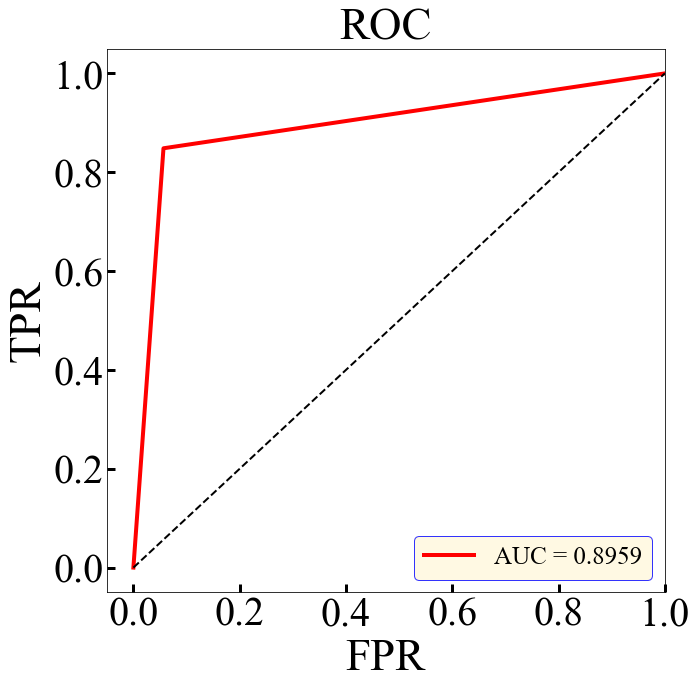

In [25]:
#ROC

%matplotlib inline
y_score = MLP_Classsifier_Test.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_true_test, y_score)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, 'r',label = "AUC = %0.4f" % roc_auc,linewidth=4)
plt.legend(loc = 'lower right',fontsize=25,facecolor='cornsilk', edgecolor='blue')
plt.plot([0, 1], [0, 1],'k--',linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.tick_params(direction='in',which='major',width=3,length=8)
plt.xticks(size=40)
plt.yticks(size=40)
plt.ylabel('TPR',size=45)
plt.xlabel('FPR',size=45)
plt.title('ROC',size=45)
#plt.savefig('D:/Data/Extended Graph/Python/ROC/BCMO-MLP.svg', format='svg')
plt.show()

In [26]:
np.random.seed(0)
Dataset_Boundary = pd.read_csv('Extended Mathews.csv')
X_Boundary=Dataset_Boundary.iloc[:,6:8]
y_Boundary=Dataset_Boundary.iloc[:,8] 
X_train_Boundary, X_test_Boundary, y_train_Boundary, y_test_Boundary = train_test_split(X_Boundary, y_Boundary, test_size=0.2)
X_train_Boundary, X_val_Boundary, y_train_Boundary, y_val_Boundary = train_test_split(X_train_Boundary, y_train_Boundary, test_size=0.2)
    
MLP_model_Boundary = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes,), activation='relu',  solver="adam",  alpha= alpha,  batch_size='auto',  
                          learning_rate='constant', learning_rate_init=0.001,   power_t=0.5, 
                          max_iter=2000, shuffle=False, random_state=None,tol=1e-4, verbose=False, warm_start=False, 
                          momentum=0.9,  nesterovs_momentum=True,early_stopping=False,
                          validation_fraction=0.1,   beta_1=0.9,  beta_2=0.999,   epsilon=1e-8,   n_iter_no_change=10,)
MLP_model_Boundary.fit(X_train_Boundary,y_train_Boundary)
y_true_Boundary_test=y_test_Boundary
y_pred_Boundary_test =MLP_model_Boundary.predict(X_test_Boundary)
y_true_Boundary_train=y_train_Boundary
y_pred_Boundary_train = MLP_model_Boundary.predict(X_train_Boundary)

print("********************* Performance results (Test set) *********************")
print("Test accuracy::", accuracy_score(y_true_Boundary_test, y_pred_Boundary_test))
print("Test precision:", precision_score(y_true_Boundary_test, y_pred_Boundary_test,pos_label=0))
print("Test recall:", recall_score(y_true_Boundary_test, y_pred_Boundary_test,pos_label=0))

********************* Performance results (Test set) *********************
Test accuracy:: 0.872093023255814
Test precision: 0.8620689655172413
Test recall: 0.9433962264150944


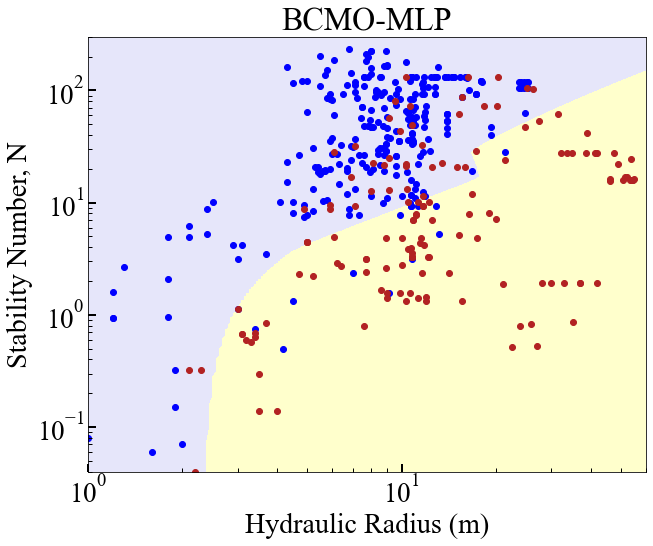

In [27]:
#Decision boundary

def plot_decision_boundary(model, axis):
    X0, X1 = np.meshgrid(np.linspace(axis[0], axis[1], 1000).reshape(-1, 1),
    np.linspace(axis[2], axis[3], 10000).reshape(-1, 1),)
    X_grid_matrix = np.c_[X0.ravel(), X1.ravel()]
    y_predict = model.predict(X_grid_matrix)
    y_predict_matrix = y_predict.reshape(X0.shape)
    from matplotlib.colors import ListedColormap
    my_colormap = ListedColormap(['#E6E6FA','#FFFFCC'])
    plt.contourf(X0, X1, y_predict_matrix,  cmap=my_colormap)
class_0 = dataset[dataset['Stability'] == 0]
class_1 = dataset[dataset['Stability'] == 1]
plt.figure(figsize=(10,8))
plot_decision_boundary(MLP_model_Boundary, axis=[1, 60, 0.04, 300])
plt.tick_params(direction='in',which='major',width=2,length=8)
plt.tick_params(direction='in',which='minor',width=1,length=4)
plt.scatter(class_0['HR'], class_0['N'], color="#0000FF", label='Class 0')
plt.scatter(class_1['HR'], class_1['N'], color="#B22222", label='Class 1')
plt.xticks(size=27)
plt.xscale('log')
plt.yticks(size=27)
plt.yscale('log')
plt.xlabel('Hydraulic Radius (m)',size=28)
plt.ylabel('Stability Number, N',size=28)
plt.title('BCMO-MLP',size=32)
#plt.savefig('D:/DATA/Extended Graph/Python/Decision boundary/BCMO-MLP.svg', format='svg')
plt.show()